In [1]:
import numpy as np
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import TfidfVectorizer

from typing import List, Dict

In [2]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()

# Move 3 levels up to the project root directory and append to sys.path
project_root = os.path.abspath(os.path.join(current_dir, '../../'))
sys.path.append(project_root)

In [3]:
from utils.preprocess import preprocess
from utils.embedding import Embeddings

In [4]:
class Summarizer:
    def __init__(self, *args, **kwargs):
        """
        Initializes the Summarizer class by loading the word embeddings.

        Args:
            *args: Variable length argument list.
            **kwargs: Arbitrary keyword arguments.
        """
        print('Loading Embedding...')
        self.word_vec = Embeddings().load_vector()
        self.key_to_index = self.word_vec.key_to_index
        self.vector_size = self.word_vec.vector_size
        print('Embedding loaded successfully.')

    def generate_centroid_tfidf(self, sentences: List[str]) -> np.ndarray:
        """
        Generates the TF-IDF centroid of important words in the given sentences.

        Args:
            sentences (List[str]): List of sentences to analyze.

        Returns:
            np.ndarray: The centroid vector of the important words.
        """
        tf = TfidfVectorizer()
        tfidf_matrix = tf.fit_transform(sentences).toarray()
        tfidf_sum = np.sum(tfidf_matrix, axis=0)
        tfidf_max = tfidf_sum.max()
        tfidf_normalized = tfidf_sum / tfidf_max

        words = tf.get_feature_names_out()
        important_terms = [
            word
            for i, word in enumerate(words)
            if word in self.key_to_index and tfidf_normalized[i] >= 0.2
        ]
        
        if not important_terms:
            print("No important terms found for centroid generation.")
            return np.zeros(self.vector_size)

        centroid = np.mean([self.word_vec[word] for word in important_terms], axis=0)
        return centroid

    def sentence_vectorizer(self, sentences: List[str]) -> Dict[int, np.ndarray]:
        """
        Converts each sentence into a vector by averaging the word embeddings of its words.

        Args:
            sentences (List[str]): List of sentences to convert to vectors.

        Returns:
            Dict[int, np.ndarray]: Dictionary mapping sentence indices to their respective vector representation.
        """
        sentence_vectors = {}
        for i, sentence in enumerate(sentences):
            words = sentence.split()
            sentence_vec = np.zeros(self.vector_size)
            word_count = 0
            for word in words:
                if word in self.key_to_index:
                    sentence_vec = np.add(sentence_vec, self.word_vec[word])
                    word_count += 1
            if word_count > 0:
                sentence_vec /= word_count  # Average the word vectors
            sentence_vectors[i] = sentence_vec
        return sentence_vectors

    def sentence_selection(self, centroid: np.ndarray, sentence_vectors: Dict[int, np.ndarray], summary_length: int) -> List[int]:
        """
        Selects the most important sentences based on their similarity to the centroid.

        Args:
            centroid (np.ndarray): The centroid vector representing important terms.
            sentence_vectors (Dict[int, np.ndarray]): Dictionary of sentence indices and their vector representations.
            summary_length (int): The maximum length of the summary in terms of sentence count.

        Returns:
            List[int]: List of selected sentence indices sorted in order of selection.
        """
        if not any(np.linalg.norm(vec) > 0 for vec in sentence_vectors.values()):
            print("No valid sentence vectors found.")
            return []

        similarities = [
            (sentence_id, 1 - cosine(centroid, vec))
            for sentence_id, vec in sentence_vectors.items()
            if np.linalg.norm(vec) > 0
        ]

        # Sort by similarity (descending order) and select top sentences
        ranked_sentences = sorted(similarities, key=lambda x: x[1], reverse=True)

        selected_sentences = []
        total_length = 0
        for sentence_id, _ in ranked_sentences:
            selected_sentences.append(sentence_id)
            total_length += len(sentence_vectors[sentence_id])
            if total_length >= summary_length:
                break

        return sorted(selected_sentences)

    def combine_sentence(self, selected_sentence_ids: List[int], sentences: List[str]) -> str:
        """
        Combines the selected sentences into a final summary.

        Args:
            selected_sentence_ids (List[int]): List of sentence indices to be included in the summary.
            sentences (List[str]): List of sentences from the original text.

        Returns:
            str: The combined summary as a string.
        """
        return '। '.join([sentences[i] for i in selected_sentence_ids])

    def show_summary(self, text: str, length_sentence_predict: float = 0.01) -> str:
        """
        Main function to generate a summary from the input text.

        Args:
            text (str): The input text to summarize.
            length_sentence_predict (float): Desired length of the summary as a proportion
                                             of the total text length (default is 0.01).

        Returns:
            str: The generated summary.
        """
        sentences = preprocess(text, remove_stopwords=False)

        # Calculate the total length of the text in characters
        total_text_length = len(text)

        if total_text_length < 500:
            length_sentence_predict = max(0.8, length_sentence_predict)
        elif total_text_length < 1500:
            length_sentence_predict = max(0.5, length_sentence_predict)
        else:
            length_sentence_predict = max(0.2, length_sentence_predict)

        # Generate centroid of important words and sentence vectors
        centroid = self.generate_centroid_tfidf(sentences)
        sentence_vectors = self.sentence_vectorizer(sentences)

        # Determine summary length (either by character limit or number of sentences)
        if length_sentence_predict < 1:
            total_char_count = sum(len(sentence) for sentence in sentences)
            length_sentence_predict = int(
                total_char_count * length_sentence_predict)

        # Select important sentences based on centroid similarity
        selected_sentence_ids = self.sentence_selection(
            centroid,
            sentence_vectors,
            length_sentence_predict
        )

        return f"{self.combine_sentence(selected_sentence_ids, sentences)}।"

In [5]:
def show_summary(text):
    summarizer = Summarizer()
    summary = summarizer.show_summary(text)

    print(f"Length of original news: {len(text)}")
    print("-" * 50)
    print(f"Length of summary: {len(summary)}")
    print("-" * 50)
    print(f"Original news: {text}")
    print("-" * 50)
    print(f"Summary: {summary}")
    
    return summary

In [6]:
news1 = """
१ पुस, काठमाडौं । नापी विभागले लिम्पियाधुरालाई समेटेर नयाँ नक्सा तयार पार्न थालेको छ । सरकारको निर्देशनबमोजिम भारतबाट अतिक्रमित नेपाली भूभागलाई समेटेर नयाँ नक्सा तयार गर्ने प्रक्रिया अगाडि बढेको विभागले जनाएको छ । ‘नयाँ नक्सा तयार गर्ने गरी प्रक्रिया अगाडि बढेको छ’, विभागका सूचना अधिकारी दामोदर ढकालले अनलाइनखबरसँग भने । संघीय संसदका राज्य व्यवस्था समिति र अन्तर्राष्ट्रिय सम्बन्ध समितिले कालापानी, लिपुलेक, लिम्पियाधुरा र सुस्तालगायतका अतिक्रमित नेपाली भूभाग समेटेर नयाँ नक्सा सार्वजनिक गर्न सरकारलाई निर्देशन दिएका छन् । सन् १८१६ मा भएको सुगौली सन्धिअनुसार नेपालको पश्चिमी सिमाना काली (महाकाली) नदी हो । सन्धिअनुसार लिम्पियाधुराबाट बग्ने काली नदी पूर्वका सम्पूर्ण भूभाग नेपालको हो । ती सम्पूर्ण भूभाग समेटेर नक्सा सार्वजनिक गर्न दिएको निर्देशन पालना नभएको भनेर आलोचना भइरहेका बेला विभागले सरकारको निर्देशनमा नयाँ नक्सा बनाउन लागेको हो । विभागका सूचना अधिकारी ढकाल भन्छन्, ‘नापी विभाग सरकारको निर्देशन पालना गर्ने निकाय हो, निर्देशन आएको छ । बाँकी निर्णय उचित समय आएपछि हुन्छ ।’ यो अवस्थामा नक्सा जारी गर्नुभन्दा पहिले कूटनीतिक पहल गर्नुपर्ने विभागका अर्का एक अधिकारी बताउँछन् । ‘तर, यो विषयलाई अन्तर्राष्ट्रियकरण गर्नुपर्ने आवाजसमेत उठिरहेको भन्दै सरकारले प्रमाणका आधारमा जति नेपाली भूभाग हो त्यसलाई समेटेर नयाँ नक्सा तयार गर्न भनेको छ । हामी सरकारले निर्णय गरेका दिन, मागेका दिन नयाँ नक्सा उपलब्ध गराउन सक्ने गरी तयारी गर्दैछौं’ ती अधिकारीले भने । ‘नयाँ नक्सा जारी गर्ने अनुकुल वातावरण’ विज्ञहरुले पनि भारतले नयाँ नक्सा जारी गरेर सीमा बहसलाई तताएका बेला नेपालले पनि आफ्ना भूभागलाई समेटेर नयाँ नक्सा जारी गर्न सक्नुपर्ने बताएका छन् । त्यसका लागि अनुकुल वातावरण तयार भएको परराष्ट्रविद हिरण्यलाल श्रेष्ठ बताउँछन् । मिनी संसदको सक्रियताले अन्तर्राष्ट्रिय स्तरमा नेपाल सीमा समस्यामा चिन्तित छ भन्ने सकारात्मक सन्देश गइरहेको उनको भनाइ छ । श्रेष्ठका अनुसार सीमा समस्या समाधानमा सरकारले राष्ट्रिय सहमति कायम गर्नु, यो विषयमा सर्वोच्च अदालतमा पुग्नु र संसदीय समितिले निरन्तर छलफल चलाउनुको विशेष अर्थ छ । उनी भन्छन्, ‘राज्यका तीनवटै निकाय सीमासम्बन्धी विषयमा चिन्तित छन् भन्ने सन्देश अन्तर्राष्ट्रिय स्तरमा गएको छ, सरकारले यसको सदुपयोग गर्न सक्नुपर्छ ।’ सरकारका प्रवक्ता सूचना तथा सञ्चार प्रविधि मन्त्री गोकुलप्रसाद बास्कोटाले अर्काको एक इन्च जमीन पनि चाहिँदैन र हाम्रो एक इञ्च पनि छाड्दैनौं भनेका थिए । सीमा बचाउ अभियानमा समेत सक्रिय श्रेष्ठ एक इञ्च पनि जमीन छाड्दैनौं भन्ने भनाइ सरकारले व्यवहारिक रुपमै कार्यान्वयन गरेर देखाउनुपर्ने बताउँछन् । सत्तारुढ दल नेपाल कम्युनिस्ट पार्टी नेकपाका सांसदहरु अग्नि सापकोटा, भीम रावललगायतले पनि सरकारलाई तत्काल नयाँ नक्सा सार्वजनिक गर्न सार्वजनिक रुपमा नै आह्वान गर्दै आएका छन् । संसदको राज्य व्यवस्था तथा सुशासन समितिले गत कात्तिक २५ गते कालापानी, लिपुलेक र लिम्पियाधुरालाई समेटेर नेपालको नयाँ नक्सा तयार गर्न सरकारलाई निर्देशन दिएको थियो । त्यसको एक महिनापछि गत मंसिर २७ गते संसदको अन्तर्राष्ट्रिय सम्बन्ध समितिले पनि लिम्पियाधुरा, लिपुलेक, कालापानी र सुस्ता लगायत अतिक्रमित नेपाली भूमि समावेश गरी नेपालको नयाँ नक्सा अविलम्ब जारी गर्न सरकारलाई निर्देशन दिएको छ । दुबै समितिले गृहमन्त्री रामबहादुर थापा र भूमि व्यवस्था मन्त्री पद्मा अर्यालसँगको छलफलपछि यस्तो निर्देशन जारी गरेका हुन् । यसअघि, ७ भदौ २०७६ मा पनि अन्तर्राष्ट्रिय सम्बन्ध समितिले सीमा समस्या समाधानको पहल लिन सरकारलाई निर्देश गरेको थियो । सदन सुरु भएपछि यो विषय जोडतोडले उठ्छ : कांग्रेस प्रमुख प्रतिपक्षी नेपाली कांग्रेसले संसद सुरु भएपछि यो विषयलाई जोडतोडले उठाउने बताएको छ । संसद अधिवेशन पुस ४ गतेका लागि आह्वान भएको छ । ‘जतिवटा संसदीय विषयत समितिले जतिपटक निर्देशन दिएको भए पनि सीमा समस्या समाधानका लागि मन्त्रिपरिषदबाट ठोस निर्णय भएको जानकारीमा आएको छैन । यस विषयमा सदन सुरु भएपछि जोडतोडले कुरा उठाउँछौं’ कांग्रेसकी सचेतक पुष्पा भुसालले अनलाइनखबरसँग भनिन् । प्रधानमन्त्री केपी शर्मा ओलीका परराष्ट्र सल्लाहाकार राजन भट्टराई मिनी संसदको निर्देशन पालनामा सरकार प्रतिवद्ध रहेको बताउँछन् । उचित समयमा नयाँ नक्सा जारी गर्ने सरकारको योजना रहेको उनले बताए । ‘अर्को पक्षसँग वार्ता गर्ने, नयाँ नक्सा जारी गर्ने विषयमा सरकारले पहल गरिरहेको छ । यो बेला राष्ट्रहितको विषयमा संसदीय समितिले चासो दिने, निर्देशनहरु जारी गर्दा ती सकारात्मक हुन्छन्’ भट्टराईले भने । तर, संसदीय समितिहरुले निर्देशन दिँदा वा सांसदहरूले समितिमा बोल्दा आफ्नो मर्यादा र राष्ट्र हितलाई ध्यानमा नराखेको उनको आरोप छ । ‘समितिले निर्देशन दिइरहँदा, र समितिमा बोलिरहँदा सांसदहरुले आफ्नो मर्यादा र राष्ट्रको हितलाई ध्यानमा राख्नुपर्छ भन्ने हो’ भट्टराईले भने । भूमि व्यवस्था मन्त्री पद्माकुमारी अर्यालले पनि सरकारले एउटा सन्दर्भ पारेर नयाँ नक्सा सार्वजनिक गर्ने सार्वजनिक अभिव्यक्ति दिइसकेकी छन् । सीमा समस्या समाधानमा हालसम्मको प्रगति भूमि व्यवस्था मन्त्री अर्यालका अनुसार भारतले नयाँ राजनीतिक नक्सा जारी गरेपछि त्यसको विरोधमा नेपाल सरकारले मुख्य चार वटा काम गरेको छ । ती चार काम हुन्– ‘विज्ञप्तिमार्फत विरोध, राष्ट्रिय सहमति निर्माण, सीमा निरीक्षण समिति गठन र कूटनीतिक नोट पठाउने कार्य । सीमा विवाद सुगौली सन्धिदेखिकै भएको र बेला–बेला सीमा समस्या उठ्ने गरेको भए पनि इतिहासमा कुनै पनि सरकारले हाम्रो सीमा यो हो भनेर भारतीय नक्साको विरोध गरेको थिएन । पछिल्लो समयमा भारतले कालापानी र लिपुलेकलाई समेटेर नयाँ नक्सा जारी गरेपछि वर्तमान सरकारले इतिहासमै पहिलो पटक विज्ञप्ति निकालेर त्यसको विरोध गरेको मन्त्री अर्याल बताउँछिन् । प्रधानमन्त्री केपी शर्मा ओलीले सर्वदलीय, सर्वपक्षीय भेला गराएर सीमा समस्याको विषयमा राष्ट्रिय सहमति कायम गराए । सबैले सरकारलाई सीमा समस्या समाधानका लागि पहल गर्न आग्रह गर्दै सहयोगको प्रतिवद्धता जनाए । यही प्रसंगलाई जोडेर कतिपयले राष्ट्रिय म्यान्डेटअनुसार सरकारले आवश्यक पहल लिन नसक्दा भारतीयहरुले नेपालमा आन्तरिक खपतका लागि यो विषय उठाएको भन्दै टिप्पणी गर्न थालेका छन् । सरकारले नेपाल–भारत र नेपाल चीन सीमा निरीक्षण समिति गठन गर्ने निर्णय गरेको छ । तर, निर्णय भएको एक महिनाभन्दा बढी समय भइसक्दा पनि समिति गठनको प्रक्रिया कहाँ पुग्यो, सार्वजनिक जानकारीमा छैन । मन्त्री अर्यालका अनुसार सीमा निरीक्षण समिति गठनका लागि मन्त्रालयहरुबाट समितिमा सदस्यहरु को को रहने ? भनेर सिफारिस गर्ने कार्य अगाडि बढेको छ । यसैगरी, सीमा विवादको विषयमा नेपाल सरकारले भारत सरकारलाई कूटनीतिक नोट पठाएको छ । यो सबैभन्दा ठूलो कदमका रुपमा सरकारका प्रवक्तासमेत रहेका सञ्चार तथा सूचना प्रविधिमन्त्री गोकुल बास्कोटा अर्थ्याउँछन् । ‘यसलाई नेपालको फस्ट स्टेप मान्नुपर्छ । भारतीय पक्षलाई सत्यका आधारमा सत्यता प्रमाणित गर्न दिनुपर्छ’ गत मंसिर २६ गते मन्त्रालयमै आयोजित पत्रकार सम्मेलनमा मन्त्री बास्कोटाले भनेका थिए । विशेष दूत पठाउने तयारी कालापानीलगायतका क्षेत्रमा देखिएको सीमा विवाद समाधानका लागि परराष्ट्रय सचिव स्तरीय समिति छ । तर समितिको बैठक बस्न सकेको छैन । सर्वे अफ इन्डियाले जारी गरेको भारतको राजनीतिक नक्सामा लिम्पियाधुरा, कालापानी, लिपुलेक लगायतका नेपाली भूमिलाई भारततिर देखाइएको छ । जसको विरोध भएपछि सरकारले कूटनीतिक नोट पठाएको छ । तर, भारतले कूटनीतिक नोटको जवाफ नै नदिएको परराष्ट्र मन्त्रालयका एक उच्च अधिकारीले जानकारी दिए । कूटनीतिक नोटको जवाफ नआइरहेका बेला प्रधानमन्त्री केपी शर्मा ओलीले सीमा समस्या लगायतका विषयमा छलफल गर्न पूर्वप्रधानमन्त्री एवं नेकपा बरिष्ठ नेता माधवकुमार नेपाललाई विशेष दूतका रुपमा भारत पठाउन लागेको विषय चर्चामा अयो । तर, यसको स्वतन्त्र पुष्टि सरकारका प्रतिनिधिले गरेका छैनन् । प्रधानमन्त्रीका परराष्ट्र सल्लाहकार राजन भट्टराई भन्छन्, ‘विशेष दूत भनेर पठाइसकेपछि सबैको जानकारीमा आइहाल्छ । अहिलेलाई यस विषयमा सार्वजनिक रुपमा बोल्ने गरी केही भएको छैन ।
"""

In [7]:
show_summary(news1)

Loading Embedding...
Embedding loaded successfully.
Length of original news: 6930
--------------------------------------------------
Length of summary: 694
--------------------------------------------------
Original news: 
१ पुस, काठमाडौं । नापी विभागले लिम्पियाधुरालाई समेटेर नयाँ नक्सा तयार पार्न थालेको छ । सरकारको निर्देशनबमोजिम भारतबाट अतिक्रमित नेपाली भूभागलाई समेटेर नयाँ नक्सा तयार गर्ने प्रक्रिया अगाडि बढेको विभागले जनाएको छ । ‘नयाँ नक्सा तयार गर्ने गरी प्रक्रिया अगाडि बढेको छ’, विभागका सूचना अधिकारी दामोदर ढकालले अनलाइनखबरसँग भने । संघीय संसदका राज्य व्यवस्था समिति र अन्तर्राष्ट्रिय सम्बन्ध समितिले कालापानी, लिपुलेक, लिम्पियाधुरा र सुस्तालगायतका अतिक्रमित नेपाली भूभाग समेटेर नयाँ नक्सा सार्वजनिक गर्न सरकारलाई निर्देशन दिएका छन् । सन् १८१६ मा भएको सुगौली सन्धिअनुसार नेपालको पश्चिमी सिमाना काली (महाकाली) नदी हो । सन्धिअनुसार लिम्पियाधुराबाट बग्ने काली नदी पूर्वका सम्पूर्ण भूभाग नेपालको हो । ती सम्पूर्ण भूभाग समेटेर नक्सा सार्वजनिक गर्न दिएको निर्देशन पालना नभएको भनेर आलोचना भइरहेक

'तर यो विषयलाई अन्तर्राष्ट्रियकरण गर्नुपर्ने आवाजसमेत उठिरहेको भन्दै सरकारले प्रमाणका आधारमा जति नेपाली भूभाग हो त्यसलाई समेटेर नयाँ नक्सा तयार गर्न भनेको छ। सरकारका प्रवक्ता सूचना तथा सञ्चार प्रविधि मन्त्री गोकुलप्रसाद बास्कोटाले अर्काको एक इन्च जमीन पनि चाहिँदैन र हाम्रो एक इञ्च पनि छाड्दैनौं भनेका थिए। त्यसको एक महिनापछि गत मंसिर २७ गते संसदको अन्तर्राष्ट्रिय सम्बन्ध समितिले पनि लिम्पियाधुरा लिपुलेक कालापानी र सुस्ता लगायत अतिक्रमित नेपाली भूमि समावेश गरी नेपालको नयाँ नक्सा अविलम्ब जारी गर्न सरकारलाई निर्देशन दिएको छ। तर निर्णय भएको एक महिनाभन्दा बढी समय भइसक्दा पनि समिति गठनको प्रक्रिया कहाँ पुग्यो सार्वजनिक जानकारीमा छैन। अहिलेलाई यस विषयमा सार्वजनिक रुपमा बोल्ने गरी केही भएको छैन।'

In [8]:
news2 = """
दाङ — टिपरको ठक्करबाट सोमबार साँझ घोराहीमा एक मोटरसाइकल चालकको मृत्यु भएको छ ।



घोराहीबाट तुलसीपुरतर्फ जाँदै गरेको रा१ख १२९१ नम्बरको टिपरले सोही दिशातर्फ जाँदै गरेको रा७प ७४६ नम्बरको मोटरसाइकललाई घोराही उपमहानगरपालिका–१० झारबैरा चोकमा ठक्कर दिंदा चालक तुलसीपुर उपमहानगरपालिका–१९ कुटीचौरका १९ वर्षीय सुदीप बुढाथोकीको मृत्यु भएको हो ।


दुर्घटनामा घाइते बुढाथोकीको उपचारका क्रममा राप्ती स्वास्थ्य विज्ञान प्रतिष्ठान घोराहीमा मृत्यु भएको जिल्ला प्रहरी प्रवक्ता डीएसपी ईश्वर थापाले बताए । मोटरसाइकलमा सवार कुटीचौरकै २२ वर्षीय दीपक बस्नेत घाइते भएका छन् । उनको राप्ती स्वास्थ्य विज्ञान प्रतिष्ठान घोराहीमा उपचार भइरहेको उनले जानकारी दिए । टिपर चालक घोराही–११, डोक्रेनाका ४० वर्षीय जितबहादुर चौधरीलाई नियन्त्रणमा राखी थप अनुसन्धान गरिरहेको डीएसपी थापाले बताए ।
"""

In [9]:
predicted_summary = show_summary(news2)

Loading Embedding...
Embedding loaded successfully.
Length of original news: 758
--------------------------------------------------
Length of summary: 325
--------------------------------------------------
Original news: 
दाङ — टिपरको ठक्करबाट सोमबार साँझ घोराहीमा एक मोटरसाइकल चालकको मृत्यु भएको छ ।



घोराहीबाट तुलसीपुरतर्फ जाँदै गरेको रा१ख १२९१ नम्बरको टिपरले सोही दिशातर्फ जाँदै गरेको रा७प ७४६ नम्बरको मोटरसाइकललाई घोराही उपमहानगरपालिका–१० झारबैरा चोकमा ठक्कर दिंदा चालक तुलसीपुर उपमहानगरपालिका–१९ कुटीचौरका १९ वर्षीय सुदीप बुढाथोकीको मृत्यु भएको हो ।


दुर्घटनामा घाइते बुढाथोकीको उपचारका क्रममा राप्ती स्वास्थ्य विज्ञान प्रतिष्ठान घोराहीमा मृत्यु भएको जिल्ला प्रहरी प्रवक्ता डीएसपी ईश्वर थापाले बताए । मोटरसाइकलमा सवार कुटीचौरकै २२ वर्षीय दीपक बस्नेत घाइते भएका छन् । उनको राप्ती स्वास्थ्य विज्ञान प्रतिष्ठान घोराहीमा उपचार भइरहेको उनले जानकारी दिए । टिपर चालक घोराही–११, डोक्रेनाका ४० वर्षीय जितबहादुर चौधरीलाई नियन्त्रणमा राखी थप अनुसन्धान गरिरहेको डीएसपी थापाले बताए ।

--------------------

---

## Evaluation using cosine similarity

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. The cosine of 0° is 1, and it is less than 1 for any other angle. It is thus a judgment of orientation and not magnitude: two vectors with the same orientation have a cosine similarity of 1, two vectors at 90° have a similarity of 0, and two vectors diametrically opposed have a similarity of -1, independent of their magnitude. Cosine similarity is particularly used in positive space, where the outcome is neatly bounded in [0,1]. The name derives from the term "directional cosine similarity measure," which is the cosine of the angle between two vectors.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

In [11]:
def calculate_normalized_cosine_similarity(
    ref_summary: str, predicted_summary: str
) -> float:
    """
    Calculate the normalized cosine similarity between the reference summary and the predicted summary.

    Args:
        ref_summary (str): The reference summary.
        predicted_summary (str): The predicted summary.

    Returns:
        float: The normalized cosine similarity value.
    """
    # Vectorize the text (using TF-IDF, for example)
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform([ref_summary, predicted_summary])

    # Normalize the vectors
    normalized_matrix = normalize(tfidf_matrix)

    # Compute cosine similarity
    similarity = cosine_similarity(normalized_matrix[0], normalized_matrix[1])
    return similarity[0][0]

In [12]:
ref_summary = "सोमबार साँझ घोराहीमा टिपरको ठक्करबाट एक मोटरसाइकल चालकको ज्यान गएको छ। रा१ख १२९१ नम्बरको टिपरले रा७प ७४६ नम्बरको मोटरसाइकललाई झारबैरा चोकमा ठक्कर दिंदा चालक सुदीप बुढाथोकीको मृत्यु भएको हो।"

In [13]:
predicted_summary = "दाङ टिपरको ठक्करबाट सोमबार साँझ घोराहीमा एक मोटरसाइकल चालकको मृत्यु भएको छ। घोराहीबाट तुलसीपुरतर्फ जाँदै गरेको रा१ख १२९१ नम्बरको टिपरले सोही दिशातर्फ जाँदै गरेको रा७प ७४६ नम्बरको मोटरसाइकललाई घोराही उपमहानगरपालिका१० झारबैरा चोकमा ठक्कर दिंदा चालक तुलसीपुर उपमहानगरपालिका१९ कुटीचौरका १९ वर्षीय सुदीप बुढाथोकीको मृत्यु भएको हो।"

In [14]:
similarity_value = calculate_normalized_cosine_similarity(
    ref_summary, predicted_summary
)
print(f"Normalized Cosine Similarity: {similarity_value}")

Normalized Cosine Similarity: 0.6221735070629067


### Plot

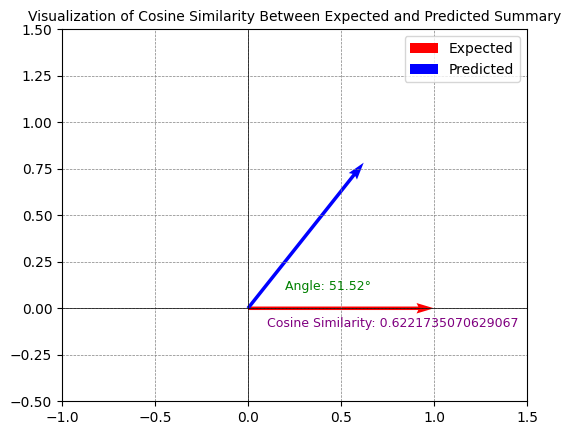

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Cosine similarity value
cosine_similarity_value = similarity_value

# Angle corresponding to the cosine similarity
angle = np.arccos(cosine_similarity_value)  # In radians

# Vectors to represent
vector1 = [1, 0]  # A unit vector along the x-axis
vector2 = [np.cos(angle), np.sin(angle)]  # A unit vector forming the calculated angle

# Plot the vectors
plt.figure(figsize=(6, 6))
plt.quiver(
    0,
    0,
    vector1[0],
    vector1[1],
    angles="xy",
    scale_units="xy",
    scale=1,
    color="red",
    label="Expected",
)
plt.quiver(
    0,
    0,
    vector2[0],
    vector2[1],
    angles="xy",
    scale_units="xy",
    scale=1,
    color="blue",
    label="Predicted",
)

# Set limits and labels
plt.xlim(-1, 1.5)
plt.ylim(-0.5, 1.5)
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.grid(color="gray", linestyle="--", linewidth=0.5)
plt.gca().set_aspect("equal", adjustable="box")

# Annotate the cosine similarity value and angle
plt.text(
    0.1,
    -0.1,
    f"Cosine Similarity: {cosine_similarity_value}",
    fontsize=9,
    color="purple",
)
plt.text(0.2, 0.1, f"Angle: {np.degrees(angle):.2f}°", fontsize=9, color="green")

plt.legend()
plt.title("Visualization of Cosine Similarity Between Expected and Predicted Summary", fontsize=10)
plt.show()